In [2]:
import ast
from pathlib import Path 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

In [3]:
def read_df(path):
    raw_df = pd.read_csv(path)
    raw_df["Latency"] = raw_df["latency"]
    raw_df["Energy"] = raw_df["energy"]
    raw_df["EDP"] = raw_df["Latency"] * raw_df["Energy"]
    raw_df.drop(["latency", "energy"], axis=1, inplace=True)
    return raw_df

def output_overlapped_ratio(raw_df):
    action_cols = ["pagepolicy", "addressmapping", "ras", "rcd", "refi", "rp", "rrd"]
    selected_df = raw_df[action_cols]
    df_unique = selected_df.drop_duplicates()
    overlapped_ratio = 1 - len(df_unique) / len(raw_df)
    print(f"overlapped ratio: {overlapped_ratio}")

def filter_large_error_rate(df):
    return df[df["episode_return"] != -1e6]

def plot_obj(df, obj_name, workload=None, target=None, window_size = 10):
    obj = df.groupby(df.index//window_size)[obj_name].mean()
    # drop index column
    obj = obj.reset_index(drop=True)
    obj = np.array(obj)
    x = [i * window_size for i in range(len(obj))]
    plt.figure(figsize=(20,6))
    plt.plot(x, obj, label="rl_agent")
    if target != None:
        plt.plot(x, [target for i in range(len(obj))], label="target")
    if workload != None:
        plt.title(f"{obj_name} for workload {workload}")
    plt.xlabel("Steps")
    plt.ylabel(obj_name)
    plt.show()

In [4]:
def filter_uname(df):
    df = df.rename(columns={"Unnamed: 0":"stats"})
    df.index = df["stats"]
    df = df.drop(["stats"], axis=1)
    df = df.T
    return df

def get_baselines():
    df = pd.read_csv("configs/micron_config_info.csv")
    df = filter_uname(df)
    micron_perf = df[["Latency", "Energy"]]
    df = pd.read_csv("configs/random_config_info.csv")
    df = filter_uname(df)
    random_perf = df[["Latency", "Energy"]]
    return micron_perf, random_perf

micron_perf, random_perf = get_baselines()
micron_perf["EDP"] = micron_perf["Latency"] * micron_perf["Energy"]
random_perf["EDP"] = random_perf["Latency"] * random_perf["Energy"]
ACTIONS_COLS = ["pagepolicy", "addressmapping", "ras", "rcd", "refi", "rp", "rrd"]

In [5]:
def get_general_target(df_total, workload):
    return df_total[workload]

def get_rl_edp(df):
    df["EDP"] = df["Latency"] * df["Energy"]
    return pd.Series({"rl_agent": df[-5:]["EDP"].min()})

def get_series(workload, df_ideal, df_target):
    series = get_general_target(df_ideal, workload)
    series = pd.concat([series, get_rl_edp(df_target)])
    return series

def get_df(path):
    raw_df = read_df(path)
    df = filter_large_error_rate(raw_df)
    return df

def get_perf(workloads, suffixs, base_dir):
    df_ideal = pd.DataFrame({"general": micron_perf["EDP"].tolist(), "target": random_perf["EDP"].tolist()})
    df_ideal.index = random_perf.index.tolist()
    df_ideal = df_ideal.T

    series_all = []
    df_all = []
    for suffix, workload in zip(suffixs, workloads):
        path = f"{base_dir}/{workload}{suffix}.csv"
        df = get_df(path)
        df_all.append((workload, df))
        series = get_series(workload, df_ideal, df)
        series_all.append(series)

    df = pd.concat(series_all, axis=1)
    df.columns = [f"{workload}{suffix}" for suffix, workload in zip(suffixs, workloads)]
    df = df.T
    df_normalized = df.div(df["general"], axis=0)
    df_normalized = df_normalized.reindex(['general', 'rl_agent', 'target'], axis=1)
    df_normalized = df_normalized.sort_values("target")
    df_perf = df_normalized.round(3)
    return df_perf, df_all

overlapped ratio: 0.0


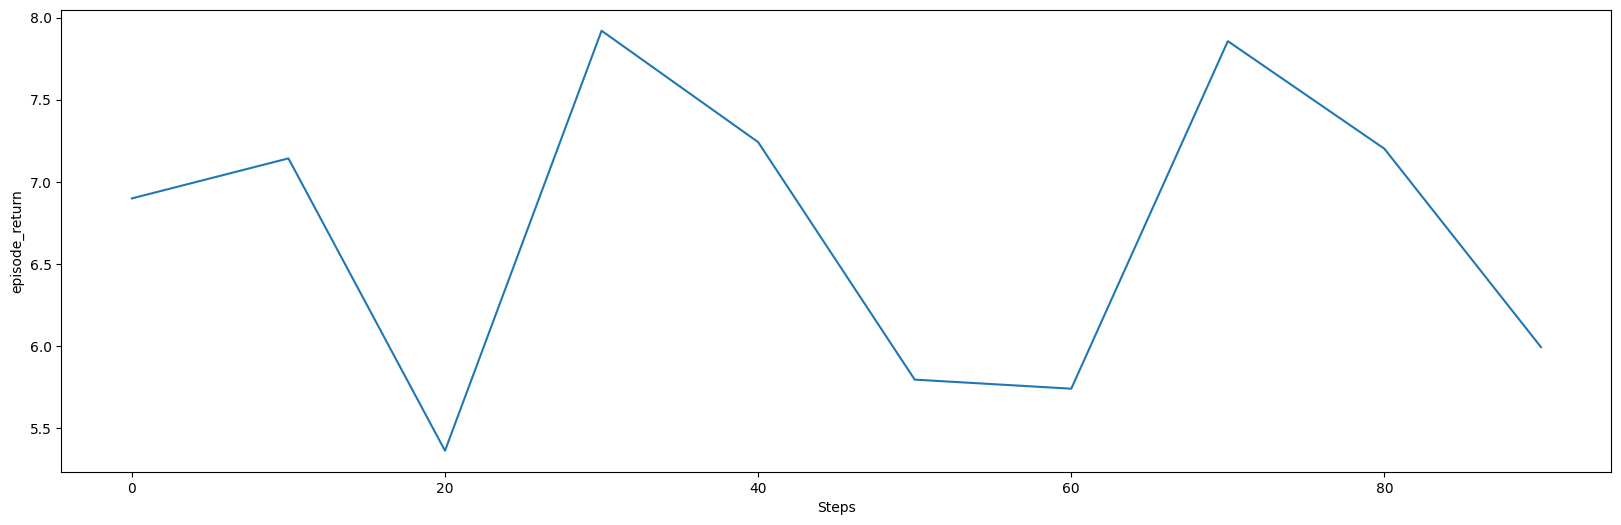

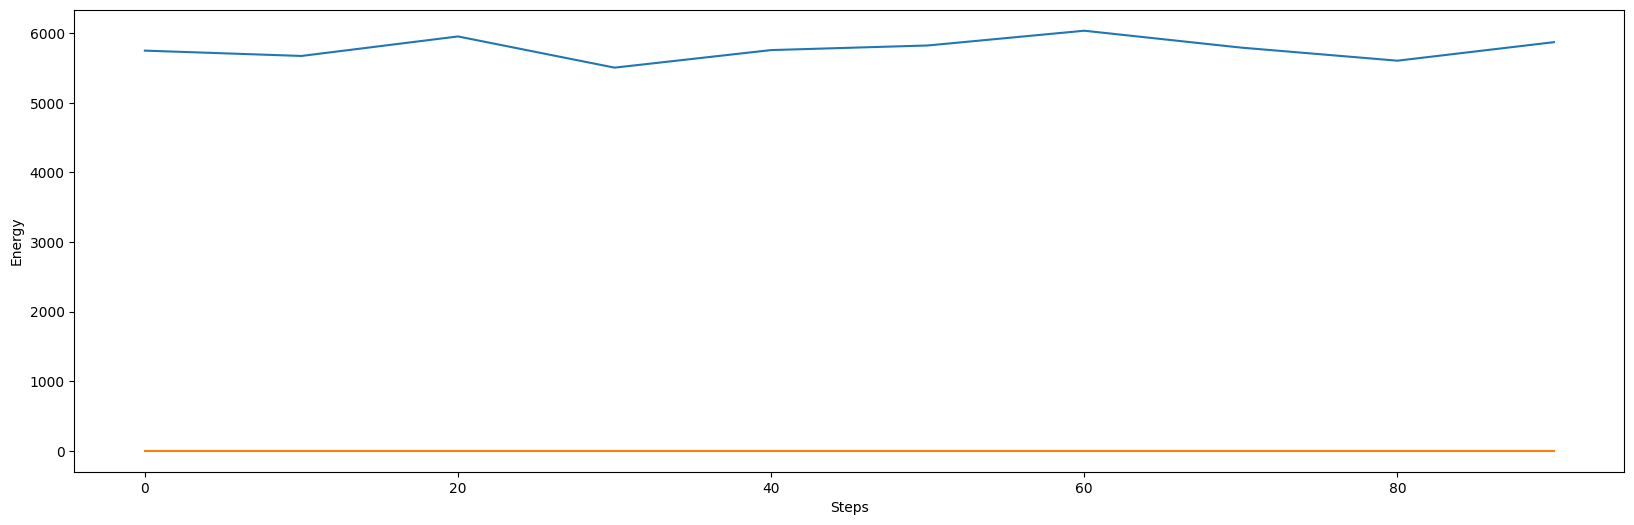

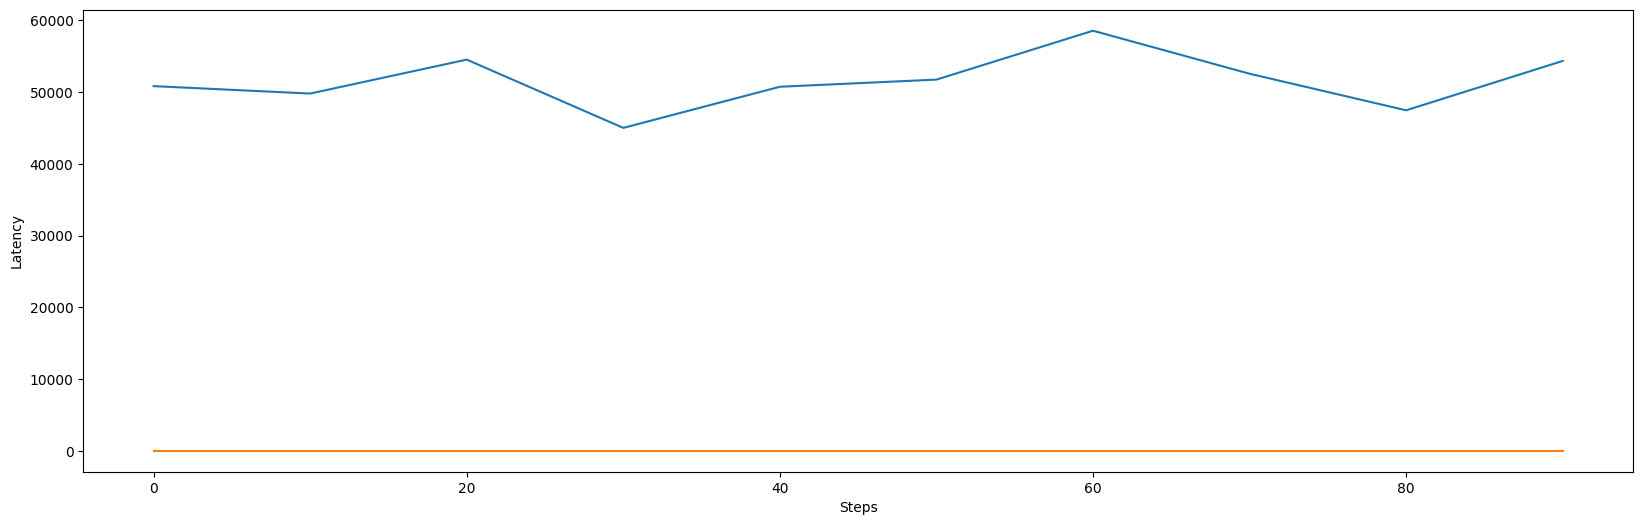

In [6]:
workload = "swaptions"
raw_df = read_df(f"logs.csv")
output_overlapped_ratio(raw_df)
df = filter_large_error_rate(raw_df)
plot_obj(df, "episode_return", window_size=10)
target = random_perf["Energy"][random_perf.index == workload].values[0]
plot_obj(df, "Energy", target=target, window_size=10)
target = random_perf["Latency"][random_perf.index == workload].values[0]
plot_obj(df, "Latency", target=target, window_size=10)

### Mixed Workload Analysis

In [7]:
def get_perf(rl_perf, cl_perf, rl_period = 1600, cl_period = 2000):
    total_perf = (rl_perf.mean() * rl_period + cl_perf * cl_period) / (rl_period + cl_period)
    return total_perf
    
def get_perf_at_dif_interval(rl_perf, cl_perf, workload):
    total_perf = get_perf(rl_perf, cl_perf, rl_period = 500, cl_period = 3100)
    get_60mins_speedup = micron_perf["EDP"][workload] / total_perf
    total_perf = get_perf(rl_perf, cl_perf, rl_period = 500, cl_period = 2500)
    get_50mins_speedup = micron_perf["EDP"][workload] / total_perf
    total_perf = get_perf(rl_perf, cl_perf, rl_period = 500, cl_period = 1900)
    get_40mins_speedup = micron_perf["EDP"][workload] / total_perf
    total_perf = get_perf(rl_perf, cl_perf, rl_period = 500, cl_period = 1300)
    get_30mins_speedup = micron_perf["EDP"][workload] / total_perf
    total_perf = get_perf(rl_perf, cl_perf, rl_period = 500, cl_period = 700)
    get_20mins_speedup = micron_perf["EDP"][workload] / total_perf
    total_perf = get_perf(rl_perf, cl_perf, rl_period = 500, cl_period = 100)
    get_10mins_speedup = micron_perf["EDP"][workload] / total_perf
    return [get_10mins_speedup, get_20mins_speedup, get_30mins_speedup, get_40mins_speedup, get_50mins_speedup, get_60mins_speedup]

In [8]:
workloads = ["freqmine", "ferret", "swaptions"]
speedup_all = []
for i, workload in enumerate(workloads):
    path = f"mixed_workload_analysis/data/rl/logs{i}.csv"
    df = pd.read_csv(path)
    rl_perf = df["latency"] * df["energy"]
    path = f"mixed_workload_analysis/data/cl/logs{i}.csv"
    df = pd.read_csv(path)
    cl_perf = df["latency"] * df["energy"]
    cl_perf = cl_perf[-10:].min()
    workload = workloads[i]
    speedup = get_perf_at_dif_interval(rl_perf, cl_perf, workload)
    speedup_all.append(speedup)

from scipy.stats import gmean
tmp = np.array(speedup_all)
gmean(tmp, axis=0)

array([0.99145753, 1.06088519, 1.08669383, 1.10016881, 1.1084469 ,
       1.11404868])

### Continuity Analysis

In [9]:
def get_target_detail(workload):
    targets = {
        "swaptions": (5.1, 0.7),
        "ferret": (118.2, 15.6),
        "freqmine": (205.0, 27.5),
        "hmmer": (22765.5, 1961.7),
        "copy": (3518.3, 594.3),
        "sphinx3": (32743.3, 3294.7),
        "namd": (27743.9, 2512.4),
        "xz": (30487.7, 4022.6),
        "GemsFDTD": (69334.6, 9777.9),
        "fotonik3d": (69345.7, 9206.1),
        "zeusmp": (90955.5, 14942.0),
        "cactusADM": (33773.1, 3329.5),
        "triad": (4405.8, 823.9),
        "lbm": (64996.2, 12162.8),
        "parest": (42506.4, 5674.6),
    }
    
    if workload not in targets:
        raise ValueError(f"No target value for this workload: {workload}")
    
    return targets[workload]

def get_reward(workload, obs):
    target_latency, target_energy = get_target_detail(workload)
    latency_normalize = target_latency / abs(obs[0] - target_latency)
    energy_normalize = target_energy / abs(obs[1] - target_energy)
    reward = latency_normalize * energy_normalize
    return reward

#obs_all:all workload
def get_reward_all(workload_sequence, obs_all):
    reward_all = []
    for workload, obs in zip(workload_sequence, obs_all):
        reward = get_reward(workload, obs)
        reward_all.append(reward)
    return reward_all

micron_obs_all = micron_perf[["Latency", "Energy"]].to_numpy()
micron_workload_sequence = micron_perf.index.to_numpy()
micron_perf["reward"] = get_reward_all(micron_workload_sequence, micron_obs_all)
random_obs_all = random_perf[["Latency", "Energy"]].to_numpy()
random_workload_sequence = random_perf.index.to_numpy()
random_perf["reward"] = get_reward_all(random_workload_sequence, random_obs_all)

In [10]:
def get_ideal(df_ideal, workload):
    return df_ideal[workload]

def get_rl_edp(df):
    df["EDP"] = df["Latency"] * df["Energy"]
    return pd.Series({"rl_agent": df[-5:]["EDP"].min()})

def get_series(workload, df_ideal, df_target):
    series = get_ideal(df_ideal, workload)
    series = pd.concat([series, get_rl_edp(df_target)])
    return series

def get_df(path):
    raw_df = read_df(path)
    df = filter_large_error_rate(raw_df)
    if len(df) < len(raw_df):
        print(f"Inference : {path} meets large error rate")
    return raw_df

def get_rl_reward(workload, df):
    selected_idx = df[-5:]["EDP"].idxmin()
    reward = get_reward(workload, [df.loc[selected_idx]["Latency"], df.loc[selected_idx]["Energy"]])
    return pd.Series({"rl_agent": reward})

def get_series_reward(workload, df_ideal, df_target):
    series = get_ideal(df_ideal, workload)
    series = pd.concat([series, get_rl_reward(workload, df_target)])
    return series

def get_reward_modi(workloads, suffixs, base_dir):
    df_ideal = pd.DataFrame({"general": micron_perf["reward"].tolist(), "target": random_perf["reward"].tolist()})
    df_ideal.index = micron_perf.index.tolist()
    df_ideal = df_ideal.T

    series_all = []
    df_all = []
    for _, workload in zip(suffixs, workloads):
        path = f"{base_dir}/{workload}/logs/evaluator/logs.csv"
        df = get_df(path)
        df_all.append((workload, df))
        series = get_series_reward(workload, df_ideal, df)
        series_all.append(series)

    df = pd.concat(series_all, axis=1)
    df.columns = [f"{workload}{suffix}" for suffix, workload in zip(suffixs, workloads)]
    df = df.T
    df = df.reindex(['general', 'rl_agent', 'target'], axis=1)
    df_perf = df.round(3)
    return df_perf, df_all

In [ ]:
workloads = ["cactusADM", "hmmer", "parest", "zeusmp"]
suffixs = ["", "", "", ""]
base_dir = f"continuity_analysis/wocl/rename"
df_perf, df_all = get_reward_modi(workloads, suffixs, base_dir)
action_df = pd.concat([df_all[i][1][ACTIONS_COLS] for i, workload in enumerate(workloads)])
action_df.index = workloads
action_df, df_perf

(           pagepolicy  addressmapping  ras  rcd    refi  rp  rrd
 cactusADM           1               2   38   12  379080  13    6
 hmmer               1               2   39   12  379080  12    5
 parest              1               2   38   12  379080  13    6
 zeusmp              1               2   38   12  379080  13    6,
            general  rl_agent  target
 cactusADM    3.078    25.376  23.860
 hmmer        1.410    26.255  23.345
 parest       8.662     7.816  17.096
 zeusmp      13.554    22.461  66.930)

In [ ]:
workloads = ["cactusADM", "hmmer", "parest", "zeusmp"]
suffixs = ["", "", "", ""]
base_dir = f"continuity_analysis/cl/rename"
df_perf, df_all = get_reward_modi(workloads, suffixs, base_dir)
action_df = pd.concat([df_all[i][1][ACTIONS_COLS] for i, workload in enumerate(workloads)])
action_df.index = workloads
action_df, df_perf